In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import  OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import  RobustScaler, StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error ,median_absolute_error 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import FunctionTransformer
import shap

In [2]:
import warnings
warnings.filterwarnings("ignore") # éviter d'afficher les alertes pythons
pd.options.display.float_format = '{:.5f}'.format

In [3]:
df_data = pd.read_feather('cleaned_data.feather')

In [4]:
df_data.isna().mean()

BuildingType                   0.00000
PrimaryPropertyType            0.00000
Neighborhood                   0.00000
YearBuilt                      0.00000
NumberofBuildings              0.00000
NumberofFloors                 0.00000
PropertyGFAParking             0.00000
PropertyGFABuilding(s)         0.00000
LargestPropertyUseType         0.00000
SecondLargestPropertyUseType   0.00000
ThirdLargestPropertyUseType    0.00000
ENERGYSTARScore                0.33782
SiteEnergyUse(kBtu)            0.00000
ComplianceStatus               0.00000
TotalGHGEmissions              0.00000
VolumBuilding                  0.00000
RatioBuildingParking           0.00000
EnergyIndicator                0.00000
dtype: float64

In [5]:
numeric_col = df_data._get_numeric_data().columns.tolist()
numeric_col

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'VolumBuilding',
 'RatioBuildingParking',
 'EnergyIndicator']

In [6]:
numeric_col = [
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
# 'ENERGYSTARScore',
 'VolumBuilding',
 'RatioBuildingParking',
 'EnergyIndicator'
]

In [7]:
categ_col = df_data.select_dtypes(exclude=['int64','float64']).columns.tolist()
categ_col

['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'ComplianceStatus']

In [8]:
categ_col = [#'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
   # 'BuildingType'
 'SecondLargestPropertyUseType',
 #'ThirdLargestPropertyUseType'
            ]

In [9]:
categ_col

['Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']

In [10]:
var_to_predict = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

In [16]:
X = df_data[numeric_col+categ_col]

In [17]:
X.describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),VolumBuilding,RatioBuildingParking,EnergyIndicator
count,1634.00000,1634.00000,1634.00000,1634.00000,1634.00000,1634.00000,1634.00000,1634.00000
mean,1962.05875,1.13403,4.16769,13124.48531,100354.54590,1105989.48960,0.71724,0.99694
std,32.68529,1.14947,6.61735,42666.04920,171293.62289,5800210.38124,2.48210,0.05525
min,1900.00000,1.00000,1.00000,0.00000,3636.00000,7272.00000,0.00000,0.00000
25%,1930.00000,1.00000,1.00000,0.00000,28375.25000,48320.50000,0.00000,1.00000
50%,1966.00000,1.00000,2.00000,0.00000,47226.00000,105104.00000,0.00000,1.00000
75%,1989.00000,1.00000,4.00000,0.00000,94853.25000,340902.00000,0.00000,1.00000
max,2015.00000,27.00000,99.00000,512608.00000,2200000.00000,124094320.00000,64.43894,1.00000


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   YearBuilt                     1634 non-null   int64  
 1   NumberofBuildings             1634 non-null   float64
 2   NumberofFloors                1634 non-null   int64  
 3   PropertyGFAParking            1634 non-null   int64  
 4   PropertyGFABuilding(s)        1634 non-null   int64  
 5   VolumBuilding                 1634 non-null   int64  
 6   RatioBuildingParking          1634 non-null   float64
 7   EnergyIndicator               1634 non-null   int64  
 8   Neighborhood                  1634 non-null   object 
 9   LargestPropertyUseType        1634 non-null   object 
 10  SecondLargestPropertyUseType  1634 non-null   object 
dtypes: float64(2), int64(6), object(3)
memory usage: 140.5+ KB


# Les prédictions de la variable :TotalGHGEmissions

In [19]:
y2 =  df_data['TotalGHGEmissions']
#y2 = np.log(1+df_data['TotalGHGEmissions'])

In [20]:
y_dist2= pd.qcut(df_data['TotalGHGEmissions'],10)

In [21]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=2,stratify=y_dist2)

In [22]:
target_encoder = TargetEncoder()
X_train2[categ_col] = target_encoder.fit_transform(X_train2[categ_col],y_train2)
X_test2[categ_col]= target_encoder.transform(X_test2[categ_col],y_test2)
#normalisation
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)


## Dummy Regressor

In [23]:
estimator_dummy = DummyRegressor(strategy = "mean") 
estimator_dummy.fit(X_train2,y_train2)

DummyRegressor()

In [24]:
y_pred2 = estimator_dummy.predict(X_test2)
y_pred2

array([128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06168324,
       128.06168324, 128.06168324, 128.06168324, 128.06

In [25]:
baseline_results =[]
r2 = r2_score(y_test2, y_pred2)
MSE = mean_squared_error(y_test2, y_pred2)
MAE = mean_absolute_error(y_test2, y_pred2)
RMSE = np.sqrt(mean_squared_error(y_test2, y_pred2))
MedAE = median_absolute_error(y_test2, y_pred2)

baseline_results.append([r2,MAE,MSE,RMSE,MedAE])
baseline= pd.DataFrame(baseline_results, columns=["R2",'MAE','MSE','RMSE','MedAE'], index=['dummyRegressor'])
baseline

,R2,MAE,MSE,RMSE,MedAE
dummyRegressor,-0.00010,131.11381,50242.30266,224.14795,96.82168


## Linear Regression

In [26]:
def apply_LinearRegression(X_train, y_train, X_test, y_test):

    estimator_LR = LinearRegression()
    params_lr = {
            'fit_intercept':[True,False], 
                           }
    grid_LR = GridSearchCV(estimator = estimator_LR, param_grid = params_lr,return_train_score=True , n_jobs = -1)
    grid_LR.fit(X_train, y_train)
    print(f" Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour {estimator_LR}: ",grid_LR.best_params_ )
    y_pred_lr = grid_LR.best_estimator_.predict(X_test)
   
    #y_test = np.expm1(y_test)
    #y_pred_lr = np.expm1(y_pred_lr)
    print("R2 = {:.3f}".format(r2_score(y_test, y_pred_lr)))
    print("MSE = {:.3f}".format(mean_squared_error(y_test, y_pred_lr)))
    return grid_LR

In [27]:
grid_lr2 = apply_LinearRegression(X_train2, y_train2, X_test2, y_test2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour LinearRegression():  {'fit_intercept': True}
R2 = 0.278
MSE = 36284.490


In [29]:
def plot_coef(grid,X):
    importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': grid.coef_ # abs 
    })
    importances = importances.sort_values(by='Importance', ascending=False)
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from coefficients', size=20)
    plt.xticks(rotation='vertical')
    plt.show()

## LASSO

In [31]:
def apply_LASSO(X_train, y_train, X_test, y_test):
    estimator_lasso =  Lasso(random_state = 2)
    params_lasso = {'alpha': np.logspace(-5, 5, 50)}
    grid_lasso = GridSearchCV(estimator = estimator_lasso, param_grid = params_lasso,return_train_score=True, n_jobs = -1)
    grid_lasso.fit(X_train, y_train)
    print(f" Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour {estimator_lasso}: ",grid_lasso.best_params_ )
    y_pred_lasso = grid_lasso.best_estimator_.predict(X_test)
    #y_test = np.expm1(y_test)
    #y_pred_lasso = np.expm1(y_pred_lasso)
    print("R2 = {:.3f}".format(r2_score(y_test, y_pred_lasso)))
    print("MSE = {:.3f}".format(mean_squared_error(y_test, y_pred_lasso)))
    return grid_lasso

In [32]:
grid_lasso2 = apply_LASSO(X_train2, y_train2, X_test2, y_test2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour Lasso(random_state=2):  {'alpha': 3.2374575428176464}
R2 = 0.267
MSE = 36812.476


## Ridge

In [65]:
def apply_ridge(X_train, y_train, X_test, y_test):
    estimator_ridge =  Ridge(random_state = 2)
    params_ridge = {   'alpha': np.logspace(-5, 4, 50)}
    grid_ridge = GridSearchCV(estimator = estimator_ridge, param_grid = params_ridge,return_train_score=True ,n_jobs = -1)
    grid_ridge.fit(X_train, y_train)
    print(f" Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour {estimator_ridge}: ",grid_ridge.best_params_ )
    y_pred_ridge = grid_ridge.best_estimator_.predict(X_test)
    #y_test = np.expm1(y_test)
    #y_pred_ridge = np.expm1(y_pred_ridge)
    print("R2 = {:.3f}".format(r2_score(y_test, y_pred_ridge)))
    print("MSE = {:.3f}".format(mean_squared_error(y_test, y_pred_ridge)))
    return grid_ridge

In [34]:
grid_ridge2 = apply_ridge(X_train2, y_train2, X_test2, y_test2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour Ridge(random_state=2):  {'alpha': 145.63484775012444}
R2 = 0.257
MSE = 37341.496


## Decision Tree

In [35]:
def apply_DTree(X_train, y_train, X_test, y_test):
    estimator_DTree =  DecisionTreeRegressor(random_state = 2)
    params_DTree={
        'criterion': ["mse", "msa"],
        'max_depth': range(2, 30), # It denotes the tree’s maximum depth.
        'min_samples_split': [2,3,4,5],
        #'splitter': ['best','random']
    }
    grid_DTree = GridSearchCV(estimator = estimator_DTree, param_grid = params_DTree,return_train_score=True, n_jobs = -1)
    grid_DTree.fit(X_train, y_train)
    print(f" Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour {estimator_DTree}: ",grid_DTree.best_params_ )
    y_pred_DTree = grid_DTree.best_estimator_.predict(X_test) 
    #y_test = np.expm1(y_test)
    #y_pred_DTree = np.expm1(y_pred_DTree)
    print("R2 = {:.3f}".format(r2_score(y_test, y_pred_DTree)))
    print("MSE = {:.3f}".format(mean_squared_error(y_test, y_pred_DTree)))
    return grid_DTree

In [36]:
grid_DTree2 = apply_DTree(X_train2, y_train2, X_test2, y_test2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour DecisionTreeRegressor(random_state=2):  {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 2}
R2 = 0.373
MSE = 31518.157


In [37]:
def plot_feature_importance(grid,X):
    importances = grid.feature_importances_
    features = X.columns
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

## Random Forest

In [38]:
def apply_Rforest(X_train, y_train, X_test, y_test):

    estimator_Rforest = RandomForestRegressor(random_state=2)
    params_Rforest = {
     #   'n_estimators': [100,200,250],
        'criterion' : ['mse', 'msa'],
        'max_features':[1.0, 'sqrt', 'log2'],
        'max_depth':range(2, 25)
    }
    grid_Rforest = GridSearchCV(estimator = estimator_Rforest, param_grid = params_Rforest,return_train_score=True,n_jobs = -1)
    grid_Rforest.fit(X_train, y_train)
    print(f" Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour {estimator_Rforest}: ",grid_Rforest.best_params_ )
    y_pred_Rforest = grid_Rforest.best_estimator_.predict(X_test)
    #y_test = np.exp(y_test)
    #y_pred_Rforest = np.exp(y_pred_Rforest)
    print("R2 = {:.3f}".format(r2_score(y_test, y_pred_Rforest)))
    print("MSE = {:.3f}".format(mean_squared_error(y_test, y_pred_Rforest)))
    return grid_Rforest

In [39]:
grid_Rforest2 = apply_Rforest(X_train2, y_train2, X_test2, y_test2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour RandomForestRegressor(random_state=2):  {'criterion': 'mse', 'max_depth': 21, 'max_features': 'sqrt'}
R2 = 0.434
MSE = 28446.427


## XGBoost

In [40]:
def apply_XGboost_GHG(X_train, y_train, X_test, y_test):
    estimator_XGboost =  XGBRegressor(random_state = 2)
    params_XGboost={
        'max_depth':[2,3,4,5],
        'learning_rate':[1e-3, 1e-2, 1e-1, 1],
       'reg_alpha' :np.logspace(-3, 5, 10),
       #'reg_lambda' : np.logspace(-3, 2, 5)
    }
    grid_XGboost = GridSearchCV(estimator = estimator_XGboost, param_grid = params_XGboost,return_train_score=True,n_jobs = -1)
    grid_XGboost.fit(X_train, y_train)
    print(f" Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour {estimator_XGboost}: ",grid_XGboost.best_params_ )
    y_pred_XGboost = grid_XGboost.best_estimator_.predict(X_test)
   # y_test = np.exp(y_test)
   # y_pred_XGboost = np.exp(y_pred_XGboost)
    print("R2 = {:.3f}".format(r2_score(y_test, y_pred_XGboost)))
    print("MSE = {:.3f}".format(mean_squared_error(y_test, y_pred_XGboost)))
    return grid_XGboost

In [41]:
grid_XGboost2 = apply_XGboost_GHG(X_train2, y_train2, X_test2, y_test2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None):  {'learning_rate': 0.1, 'max_depth': 2, 'reg_alpha': 215.44346900318823}
R2 = 0.440
MSE = 28140.160


In [220]:
#plot_feature_importance(grid_XGboost2,X)

## comparaision 

In [42]:
grids2 = {
    'LinearRegression':grid_lr2,
    'Lasso':grid_lasso2,
    'Ridge':grid_ridge2, 
    'Decision Tree':grid_DTree2,
    'Random Forest':grid_Rforest2,
    'XGboost':grid_XGboost2
    
}


In [43]:
def compare_regression_methods(grids, X_train, X_test, y_train, y_test):
    results = []
    for i, grid in enumerate(grids):
      
        y_pred = grids[grid].predict(X_test)
        r2_predict = r2_score(y_test, y_pred)
        MAE = mean_absolute_error(y_test, y_pred)
        MSE = mean_squared_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        MedAE = median_absolute_error(y_test, y_pred)
        
    
        results.append([r2_predict,MAE,MSE,RMSE,MedAE])
    return pd.DataFrame(results, columns=["R2",'MAE','MSE','RMSE','MedAE'], index=grids.keys())

In [44]:
results2 = compare_regression_methods(grids2,X_train2, X_test2, y_train2, y_test2)
results2

,R2,MAE,MSE,RMSE,MedAE
LinearRegression,0.27773,103.79483,36284.49046,190.48488,59.26447
Lasso,0.26722,103.88318,36812.47599,191.86578,61.98342
Ridge,0.25669,104.82302,37341.49639,193.23948,64.79469
Decision Tree,0.37261,92.09635,31518.15747,177.53354,41.67789
Random Forest,0.43376,84.67775,28446.42712,168.66069,33.40719
XGboost,0.43985,86.90443,28140.16028,167.75029,38.31396


In [45]:
res=pd.concat([results2], keys=['TotalGHGEmissions'])
res

R2       MAE         MSE      RMSE  \
TotalGHGEmissions LinearRegression 0.27773 103.79483 36284.49046 190.48488   
                  Lasso            0.26722 103.88318 36812.47599 191.86578   
                  Ridge            0.25669 104.82302 37341.49639 193.23948   
                  Decision Tree    0.37261  92.09635 31518.15747 177.53354   
                  Random Forest    0.43376  84.67775 28446.42712 168.66069   
                  XGboost          0.43985  86.90443 28140.16028 167.75029   

                                      MedAE  
TotalGHGEmissions LinearRegression 59.26447  
                  Lasso            61.98342  
                  Ridge            64.79469  
                  Decision Tree    41.67789  
                  Random Forest    33.40719  
                  XGboost          38.31396

## Visualisation 

In [46]:
def graph(grids, X_train, X_test, y_train, y_test):
    for  i, model in enumerate(grids):
        y_pred = grids[model].predict(X_test)
        comparison = pd.DataFrame({'y_test' : y_test, 'y_pred' : y_pred}).reset_index()
        sns.lmplot(x='y_test', y='y_pred',data=comparison )
        ax = plt.gca()
        ax.set_title(' métode {} \n'.format(model), fontweight="bold")
        plt.xlabel('y_test')
        plt.ylabel('y_pred')
        plt.show()

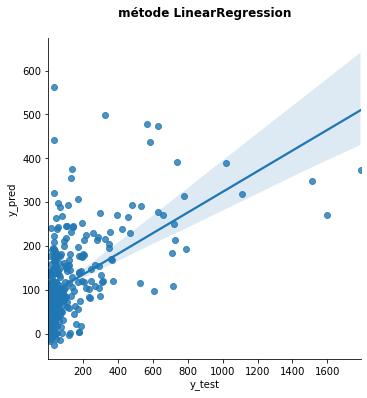

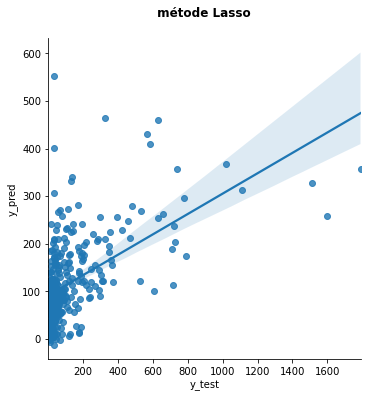

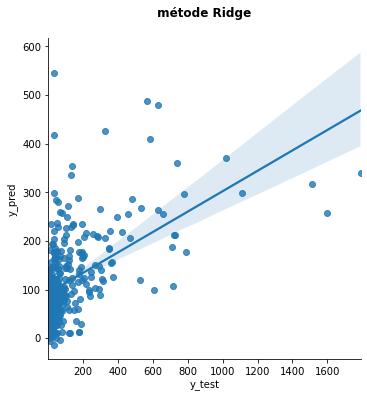

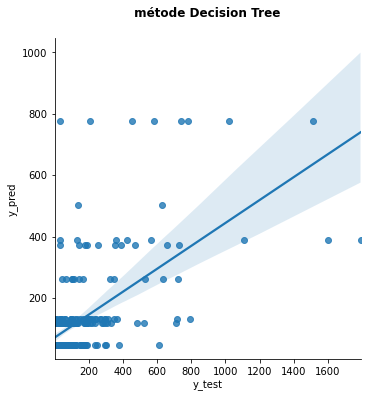

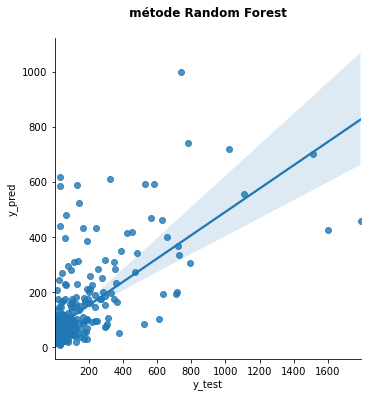

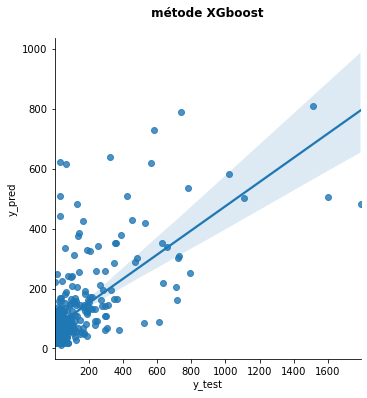

In [47]:
graph( grids2,X_train2, X_test2, y_train2, y_test2)

In [91]:
shap.initjs()

In [265]:
xgb_explainer2 = shap.TreeExplainer(XGBoost2, X_train2)

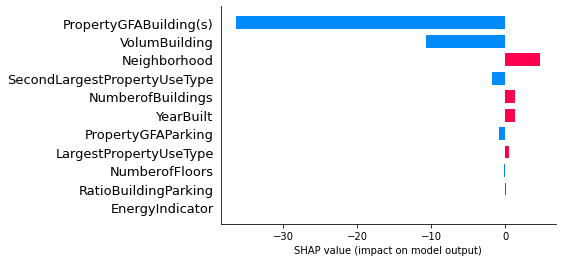

In [266]:
shap.bar_plot(xgb_explainer2.shap_values(X_test2[0]),
              feature_names=X.columns,
              max_display=len(X.columns))

# TotalGHGEmissions et EnergyStar Score

In [49]:
numeric_col_score = [
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'VolumBuilding',
 'RatioBuildingParking',

 'EnergyIndicator'
]

## Analyse de la variable 'TotalGHGEmissions' (en utilisant le score)

In [53]:
df2 = df_data.dropna()

In [54]:
df2.shape

(1082, 18)

In [50]:
numeric_col_score

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'VolumBuilding',
 'RatioBuildingParking',
 'EnergyIndicator']

In [51]:
categ_col

['Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']

In [55]:
X_score = df2[numeric_col_score+categ_col]

In [56]:
ys2 = df2['TotalGHGEmissions']

In [57]:
ys_dist2= pd.qcut(df2['TotalGHGEmissions'],5)

### Séparez les données en données d'apprentissage et de test

In [58]:
X_trainS2, X_testS2, y_trainS2, y_testS2 = train_test_split(X_score, ys2, test_size=0.2, random_state=2,stratify=ys_dist2)

In [59]:
target_encoder = TargetEncoder()
X_trainS2[categ_col] = target_encoder.fit_transform(X_trainS2[categ_col],y_trainS2,smoothing=10)
X_testS2[categ_col]= target_encoder.transform(X_testS2[categ_col],y_testS2)

In [60]:
#normalisation
scaler = StandardScaler()
X_trainS2 = scaler.fit_transform(X_trainS2)
X_testS2 = scaler.transform(X_testS2)


### Linear Regression

In [62]:
grid_lr_withscore2 = apply_LinearRegression(X_trainS2, y_trainS2, X_testS2, y_testS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour LinearRegression():  {'fit_intercept': True}
R2 = 0.226
MSE = 22059.301


In [171]:
#plot_coef(grid_lr_withscore2,X_score)

### LASSO

In [63]:
grid_lasso_withscore2 = apply_LASSO( X_trainS2, y_trainS2, X_testS2, y_testS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour Lasso(random_state=2):  {'alpha': 5.1794746792312125}
R2 = 0.237
MSE = 21743.231


In [ ]:
#plot_coef(grid_lasso_withscore2,X_score)

### Ridge

In [66]:
grid_ridge_withscore2 = apply_ridge(X_trainS2, y_trainS2, X_testS2, y_testS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour Ridge(random_state=2):  {'alpha': 62.50551925273976}
R2 = 0.241
MSE = 21647.496


In [ ]:
#plot_coef(grid_ridge_withscore2,X_score)

### Decison Tree

In [68]:
grid_DTree_withscore2 = apply_DTree(X_trainS2, y_trainS2, X_testS2, y_testS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour DecisionTreeRegressor(random_state=2):  {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 3}
R2 = 0.046
MSE = 27199.888


In [ ]:
#plot_feature_importance(grid_DTree_withscore2,X_score)

### Random Forest

In [69]:
grid_Rforest_withscore2 = apply_Rforest(X_trainS2, y_trainS2, X_testS2, y_testS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour RandomForestRegressor(random_state=2):  {'criterion': 'mse', 'max_depth': 11, 'max_features': 'sqrt'}
R2 = 0.418
MSE = 16587.609


In [ ]:
#plot_feature_importance(grid_Rforest_withscore2,X_score)

### XGBoost

In [70]:
grid_XGboost_withscore2 = apply_XGboost_GHG(X_trainS2, y_trainS2, X_testS2, y_testS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None):  {'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1668.1005372000557}
R2 = 0.429
MSE = 16276.656


In [72]:
def apply_XGBoost_best_params(grid,X_train, y_train, X_test, y_test):
    LR = XGBRegressor(**grid.best_params_,random_state=2)
    reg = LR.fit(X_train, y_train)
    y_pred_lr = reg.predict(X_test)
    print("R2 = {:.3f}".format(r2_score(y_test, y_pred_lr)))
    print("MSE = {:.3f}".format(mean_squared_error(y_test, y_pred_lr)))
    return reg

In [73]:
XGBoost2__withScore2 = apply_XGBoost_best_params(grid_XGboost_withscore2,X_trainS2, y_trainS2, X_testS2, y_testS2)

R2 = 0.429
MSE = 16276.656


In [74]:
xgb_explainer2__withScore2 = shap.TreeExplainer(XGBoost2__withScore2, X_trainS2)

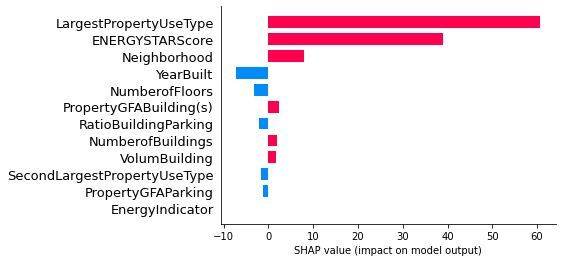

In [75]:
shap.bar_plot(xgb_explainer2__withScore2.shap_values( X_testS2[0]),
              feature_names=X_score.columns,
              max_display=len(X_score.columns))

In [179]:
#plot_feature_importance(grid_XGboost_withscore2,X_score)

### Sommaire des résultats obtenue en utilisant l'Energyscore (TotalGHGEmissions)

In [76]:
grids_withscore2 = {
    'LinearRegression':grid_lr_withscore2,
    'Lasso':grid_lasso_withscore2,
    'Ridge':grid_ridge_withscore2, 
    'Decision Tree':grid_DTree_withscore2,
    'Random Forest':grid_Rforest_withscore2,
    'XGboost':grid_XGboost_withscore2
    
}

In [77]:
results_withscore_GHGE = compare_regression_methods(grids_withscore2,X_trainS2, X_testS2, y_trainS2, y_testS2)
results_withscore_GHGE

,R2,MAE,MSE,RMSE,MedAE
LinearRegression,0.22627,90.35661,22059.30089,148.52374,50.60620
Lasso,0.23736,90.07318,21743.23107,147.45586,56.53703
Ridge,0.24072,90.40408,21647.49602,147.13088,55.33434
Decision Tree,0.04597,86.47635,27199.88761,164.92388,31.92973
Random Forest,0.41819,75.54552,16587.60921,128.79289,33.92925
XGboost,0.42910,77.24139,16276.65635,127.58000,34.87472


### Visualisation

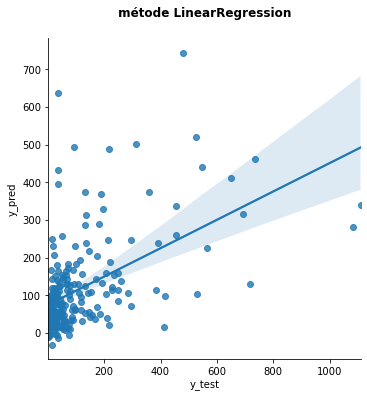

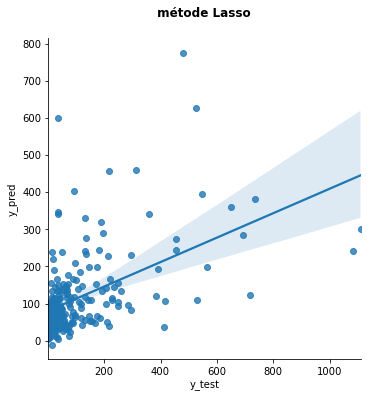

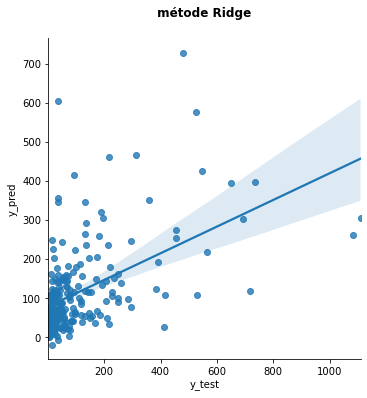

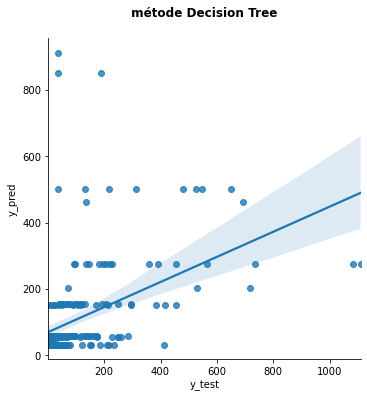

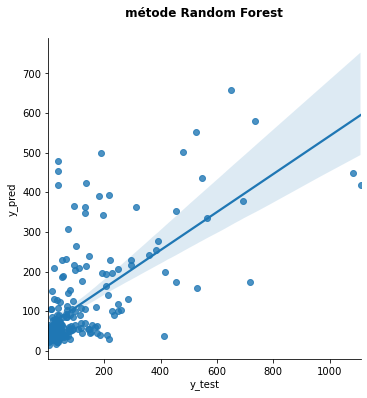

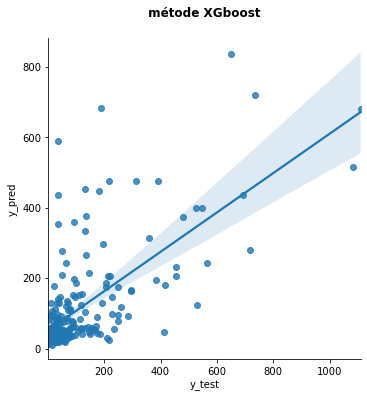

In [78]:
graph( grids_withscore2,X_trainS2, X_testS2, y_trainS2, y_testS2)

##  Analyse de la variable 'TotalGHGEmissions' (SANS le score)

In [79]:
var_to_predict

['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

In [80]:
numeric_col

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'VolumBuilding',
 'RatioBuildingParking',
 'EnergyIndicator']

In [81]:
categ_col

['Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']

In [84]:
X_Nscore = df2[numeric_col+categ_col]

In [85]:
X_Nscore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082 entries, 0 to 1629
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   YearBuilt                     1082 non-null   int64  
 1   NumberofBuildings             1082 non-null   float64
 2   NumberofFloors                1082 non-null   int64  
 3   PropertyGFAParking            1082 non-null   int64  
 4   PropertyGFABuilding(s)        1082 non-null   int64  
 5   VolumBuilding                 1082 non-null   int64  
 6   RatioBuildingParking          1082 non-null   float64
 7   EnergyIndicator               1082 non-null   int64  
 8   Neighborhood                  1082 non-null   object 
 9   LargestPropertyUseType        1082 non-null   object 
 10  SecondLargestPropertyUseType  1082 non-null   object 
dtypes: float64(2), int64(6), object(3)
memory usage: 101.4+ KB


In [86]:
yNs2 = df2['TotalGHGEmissions']

### Séparez les données en données d'apprentissage et de test

In [88]:
X_trainNS2, X_testNS2, y_trainNS2, y_testNS2 = train_test_split(X_Nscore, yNs2, test_size=0.2, random_state=2,stratify=ys_dist2)

In [89]:
target_encoder = TargetEncoder()
X_trainNS2[categ_col] = target_encoder.fit_transform(X_trainNS2[categ_col],y_trainNS2,smoothing=10)
X_testNS2[categ_col]= target_encoder.transform(X_testNS2[categ_col],y_testNS2)
X_testNS2[categ_col]

,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType
599,123.23864,244.18150,167.84786
519,151.96433,109.84674,100.59788
946,59.10006,37.65058,100.59788
37,59.10006,109.84674,78.27410
271,191.40572,109.84674,150.83905
...,...,...,...
169,84.47250,100.02966,100.59788
366,191.40572,109.84674,167.84786
1496,123.23864,37.65058,100.59788
798,133.36735,109.84674,167.84786


In [90]:
#normalisation
scaler = StandardScaler()
X_trainNS2 = scaler.fit_transform(X_trainNS2)
X_testNS2 = scaler.transform(X_testNS2)
X_testNS2

array([[ 1.24098672, -0.09945875,  0.13719414, ...,  0.05197873,
         2.1141799 ,  1.4208003 ],
       [ 1.17847123, -0.09945875, -0.11557036, ...,  0.65357487,
        -0.18857776, -0.60975365],
       [ 0.45954307, -0.09945875, -0.49471712, ..., -1.29126236,
        -1.42615944, -0.60975365],
       ...,
       [-0.16561185, -0.09945875, -0.36833486, ...,  0.05197873,
        -1.42615944, -0.60975365],
       [ 0.67834729, -0.09945875, -0.24195261, ...,  0.2641021 ,
        -0.18857776,  1.4208003 ],
       [ 1.11595574, -0.09945875, -0.11557036, ..., -0.75989257,
         2.1141799 ,  1.4208003 ]])

### Linear Regression

In [91]:
grid_lr_withoutScore2 = apply_LinearRegression(X_trainNS2, y_trainNS2, X_testNS2, y_testNS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour LinearRegression():  {'fit_intercept': True}
R2 = 0.225
MSE = 22094.449


### LASSO

In [92]:
grid_lasso_withoutScore2 = apply_LASSO(X_trainNS2, y_trainNS2, X_testNS2, y_testNS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour Lasso(random_state=2):  {'alpha': 8.286427728546842}
R2 = 0.222
MSE = 22184.613


### Ridge

In [93]:
grid_ridge_withoutScore2 = apply_ridge(X_trainNS2, y_trainNS2, X_testNS2, y_testNS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour Ridge(random_state=2):  {'alpha': 95.40954763499944}
R2 = 0.235
MSE = 21823.127


### Decision Tree

In [94]:
grid_DTree_withoutScore2 = apply_DTree(X_trainNS2, y_trainNS2, X_testNS2, y_testNS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour DecisionTreeRegressor(random_state=2):  {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 5}
R2 = 0.210
MSE = 22534.234


### Random Forest

In [95]:
grid_Rforest_withoutScore2 = apply_Rforest(X_trainNS2, y_trainNS2, X_testNS2, y_testNS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour RandomForestRegressor(random_state=2):  {'criterion': 'mse', 'max_depth': 19, 'max_features': 'sqrt'}
R2 = 0.419
MSE = 16552.036


In [ ]:
#plot_feature_importance(grid_Rforest_withoutScore2,X_Nscore)

### XGBoost

In [96]:
grid_XGboost_withoutScore2 = apply_XGboost_GHG(X_trainNS2, y_trainNS2, X_testNS2, y_testNS2)

 Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None):  {'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 0.05994842503189409}
R2 = 0.515
MSE = 13830.546


In [97]:
XGBoost2__withoutScore2 = apply_XGBoost_best_params(grid_XGboost_withoutScore2,X_trainNS2, y_trainNS2, X_testNS2, y_testNS2)

R2 = 0.515
MSE = 13830.546


In [98]:
shap.initjs()

In [99]:
xgb_explainer2__withoutScore2 = shap.TreeExplainer(XGBoost2__withoutScore2, X_trainNS2)

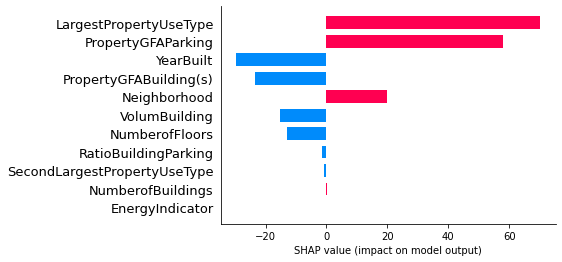

In [100]:
shap.bar_plot(xgb_explainer2__withoutScore2.shap_values( X_testNS2[0]),
              feature_names=X_Nscore.columns,
              max_display=len(X_Nscore.columns))

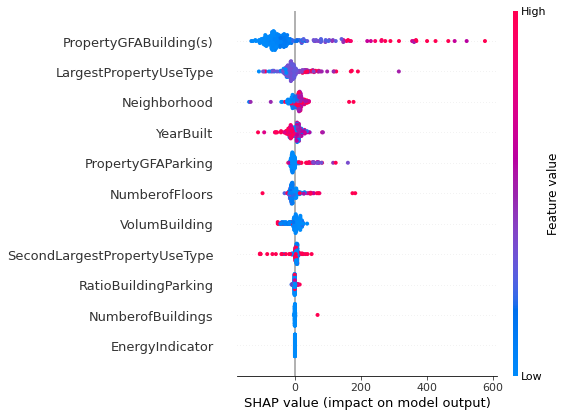

In [101]:
shap.summary_plot(xgb_explainer2__withoutScore2.shap_values(X_testNS2),
                  features = X_testNS2,
                  feature_names=X_Nscore.columns)

### Sommaire des résultats obtenue sans utiliser l'Energyscore (TotalGHGEmissions)

In [102]:
grids_withoutScore2 = {
    'LinearRegression':grid_lr_withoutScore2,
    'Lasso':grid_lasso_withoutScore2,
    'Ridge':grid_ridge_withoutScore2, 
    'Decision Tree':grid_DTree_withoutScore2,
    'Random Forest':grid_Rforest_withoutScore2,
    'XGboost':grid_XGboost_withoutScore2
}

In [103]:
results_withoutScore_GHGE= compare_regression_methods(grids_withoutScore2,X_trainNS2, X_testNS2, y_trainNS2, y_testNS2)
results_withoutScore_GHGE

,R2,MAE,MSE,RMSE,MedAE
LinearRegression,0.22504,91.19968,22094.44879,148.64202,53.81463
Lasso,0.22188,92.18623,22184.61279,148.94500,64.50297
Ridge,0.23456,91.98894,21823.12733,147.72653,59.53178
Decision Tree,0.20961,81.17389,22534.23447,150.11407,38.02694
Random Forest,0.41944,77.73072,16552.03643,128.65472,40.28479
XGboost,0.51489,73.99236,13830.54644,117.60334,36.01245


In [104]:
scores_GHGEmissions = pd.concat([results_withscore_GHGE, results_withoutScore_GHGE], keys=['Score', 'NoScore'])
scores_GHGEmissions

R2      MAE         MSE      RMSE    MedAE
Score   LinearRegression 0.22627 90.35661 22059.30089 148.52374 50.60620
        Lasso            0.23736 90.07318 21743.23107 147.45586 56.53703
        Ridge            0.24072 90.40408 21647.49602 147.13088 55.33434
        Decision Tree    0.04597 86.47635 27199.88761 164.92388 31.92973
        Random Forest    0.41819 75.54552 16587.60921 128.79289 33.92925
        XGboost          0.42910 77.24139 16276.65635 127.58000 34.87472
NoScore LinearRegression 0.22504 91.19968 22094.44879 148.64202 53.81463
        Lasso            0.22188 92.18623 22184.61279 148.94500 64.50297
        Ridge            0.23456 91.98894 21823.12733 147.72653 59.53178
        Decision Tree    0.20961 81.17389 22534.23447 150.11407 38.02694
        Random Forest    0.41944 77.73072 16552.03643 128.65472 40.28479
        XGboost          0.51489 73.99236 13830.54644 117.60334 36.01245

In [105]:
total_score = pd.concat([scores_GHGEmissions], keys=['TotalGHGEmissions'])
total_score

R2      MAE         MSE  \
TotalGHGEmissions Score   LinearRegression 0.22627 90.35661 22059.30089   
                          Lasso            0.23736 90.07318 21743.23107   
                          Ridge            0.24072 90.40408 21647.49602   
                          Decision Tree    0.04597 86.47635 27199.88761   
                          Random Forest    0.41819 75.54552 16587.60921   
                          XGboost          0.42910 77.24139 16276.65635   
                  NoScore LinearRegression 0.22504 91.19968 22094.44879   
                          Lasso            0.22188 92.18623 22184.61279   
                          Ridge            0.23456 91.98894 21823.12733   
                          Decision Tree    0.20961 81.17389 22534.23447   
                          Random Forest    0.41944 77.73072 16552.03643   
                          XGboost          0.51489 73.99236 13830.54644   

                                                RMSE    MedAE  
TotalGHGEmissions Score   LinearRegression 148.52374 50.60620  
                          Lasso            147.45586 56.53703  
                          Ridge            147.13088 55.33434  
                          Decision Tree    164.92388 31.92973  
                          Random Forest    128.79289 33.92925  
                          XGboost          127.58000 34.87472  
                  NoScore LinearRegression 148.64202 53.81463  
                          Lasso            148.94500 64.50297  
                          Ridge            147.72653 59.53178  
                          Decision Tree    150.11407 38.02694  
                          Random Forest    128.65472 40.28479  
                          XGboost          117.60334 36.01245